In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, accuracy_score, classification_report, recall_score
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import Isomap
from os.path import join
from svae_model import SupervisedVAE
from sklearn.neighbors import NearestNeighbors
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
        
set_seed(42)

In [3]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [4]:
# Correct an issue with the 'Repeater' column in the DataFrame
def fill_repeater_from_source(row, data):
    if row['Source'] == 'FRB20220912A':
        return 1
    else:
        return row['Repeater']

In [5]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)
frb_data['Repeater'] = frb_data.apply(fill_repeater_from_source, axis=1, data=frb_data)

frb_data['Repeater'].isna().sum()

np.int64(0)

In [6]:
labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 
    #'Scin_f'
]
base_features = [
    'Observing_band', 
    # 'GL', 'GB', 
    
    'SNR', 
    'Freq_high',
    'Freq_low', 'Freq_peak', 
    'Width'
    # 'Repeater',
    #'MJD'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [7]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [8]:
def loss_function(recon_x, x, mu, logvar, class_prob, labels, beta, gamma, class_weight, classification_multiplier):
    reconstruction_loss_fn = nn.MSELoss(reduction='sum')
    pos_weight = torch.tensor([class_weight], dtype=torch.float32, device=device)
    classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # check this loss function
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_multiplier * classification_loss_fn(class_prob, labels.unsqueeze(1).float())
    total_loss = recon_loss + beta * kl_loss + gamma * class_loss
    return total_loss, recon_loss, kl_loss, class_loss

In [9]:
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [10]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0})
print(original_data['Repeater'].isna().sum())

print(f"Number of NaN values in 'Repeater' column before processing: {original_data['Repeater'].isna().sum()}")
# Apply the function row-wise
original_data['Repeater'] = original_data.apply(fill_repeater_from_source, axis=1, data=original_data)

print(f"Number of NaN values in 'Repeater' column after processing: {original_data['Repeater'].isna().sum()}")

443
Number of NaN values in 'Repeater' column before processing: 443
Number of NaN values in 'Repeater' column after processing: 0


In [12]:
best_params = {'hidden_dim': 1082, 'latent_dim': 18, 'beta': 1.149574612306723, 'gamma': 1.9210647260496314, 'dropout_rate': 0.13093239424733344, 'lr': 0.0011823749066137313, 'scheduler_patience': 7, 'class_weight': 0.35488674730648145, 'activation': 'ReLU', 'classification_multiplier': 7817.124805902009}

beta = best_params["beta"]
gamma = best_params["gamma"]
lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [13]:
def train_supervised(model, optimizer, scheduler, epoch, beta, gamma, class_weight, classification_multiplier):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        # if batch_idx % 100 == 0:
            # print(classification_loss)
            # print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
            #       f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised(model, scheduler, optimizer, epoch, beta, gamma, class_weight, classification_multiplier):
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels, beta, gamma, class_weight, classification_multiplier
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    # print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
    #       f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False



In [14]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [15]:
all_false_positives = """FRB20181102A
FRB20180309A
FRB20141113A
FRB20190221B
FRB20210213A
FRB20210303A
FRB20200514B
FRB20211212A
FRB20220506D
FRB20150418A
FRB20190423B
FRB20010621A
FRB20190429B
FRB20010125A
FRB20191109A
FRB20190625A
FRB20191020B
FRB20220725A
FRB20210408H
FRB20190420A
FRB20180907E
FRB20140514A
FRB20010305A
FRB20110523A
FRB20010312A
FRB20190714A
FRB20191221A
FRB20210206A
FRB20221101A
FRB20230718A
FRB20190112A
FRB20200917A
FRB20200125A
FRB20200405A
FRB20210202D""".split('\n')

all_false_positives

['FRB20181102A',
 'FRB20180309A',
 'FRB20141113A',
 'FRB20190221B',
 'FRB20210213A',
 'FRB20210303A',
 'FRB20200514B',
 'FRB20211212A',
 'FRB20220506D',
 'FRB20150418A',
 'FRB20190423B',
 'FRB20010621A',
 'FRB20190429B',
 'FRB20010125A',
 'FRB20191109A',
 'FRB20190625A',
 'FRB20191020B',
 'FRB20220725A',
 'FRB20210408H',
 'FRB20190420A',
 'FRB20180907E',
 'FRB20140514A',
 'FRB20010305A',
 'FRB20110523A',
 'FRB20010312A',
 'FRB20190714A',
 'FRB20191221A',
 'FRB20210206A',
 'FRB20221101A',
 'FRB20230718A',
 'FRB20190112A',
 'FRB20200917A',
 'FRB20200125A',
 'FRB20200405A',
 'FRB20210202D']

In [16]:
best_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

best_model.load_state_dict(torch.load("weights/model_weights.pth", map_location=device))

result = evaluate_classifier_full(best_model, val_loader, device)

result[2]

array([[ 139,   11],
       [   9, 1574]])

In [17]:
global_font_size = 26
global_figsize = (10, 6)  

In [27]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)



matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'font.size':           global_font_size,
    # Titles, labels, ticks, legends all at 12 pt
    'axes.titlesize':      global_font_size,
    'axes.labelsize':      global_font_size,
    'xtick.labelsize':     global_font_size,
    'ytick.labelsize':     global_font_size,
    'legend.fontsize':     0.82 * global_font_size,
    'figure.titlesize':    global_font_size,
    # ensure a LaTeX package for scalable fonts
    'text.latex.preamble': r'\usepackage{lmodern}'
})


def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def natural_keys(text):
    """Helper to sort text alphanumerically."""
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', text)]


def visualize_latent_space_pca(latent_representations, labels,
                               title='PCA of Latent Space Representations',
                               file_path='figs', loc='upper right', palette='tab10', label_pos = (0.05, 0.95)):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('PCA Dimension 1')
    ax.set_ylabel('PCA Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )

    ax.text(label_pos[0], label_pos[1], 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()


def cluster_and_visualize(latent_representations, labels,
                          title='Clusters in PCA-Transformed Latent Space',
                          file_path='figs'):
    latent_2d = PCA(n_components=2).fit_transform(latent_representations)

    n_clusters = len(np.unique(labels))
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=42) \
                     .fit_predict(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=cluster_labels, palette='viridis',
                    s=60, alpha=0.8, ax=ax)

    ax.set_title(title)
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_,
              title='Class',
            )

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()

    print(f"Silhouette Score: {silhouette_score(latent_2d, cluster_labels)}")
    print(f"Adjusted Rand Index (ARI): {adjusted_rand_score(labels, cluster_labels)}")



def visualize_latent_space_tsne(latent_representations, labels,
                               title='t-SNE of Latent Space Representations',
                               palette='tab20', file_path='figs', loc='upper right', n_col = 1, many_classes=False, label_pos = (0.05, 0.95), hide_legend=False):
    latent_2d = TSNE(n_components=2, random_state=42) \
                .fit_transform(latent_representations)
                
                
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)
    

    fig, ax = plt.subplots(figsize=global_figsize)
    scatter = sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                              hue=labels, palette=palette,
                              s=60, alpha=0.8, ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    
    # set x limit to 5

    if many_classes:
        bottom_range_x = np.min(latent_2d[:, 0]) - 0.5
        top_range_x = np.max(latent_2d[:, 0]) + 1.8
        ax.set_xlim(bottom_range_x, top_range_x)

    # Sort legend alphanumerically
    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)
    
    ax.legend(handles, labels_,
              borderpad=0.2,
              # reduce space between entries
              labelspacing=0.1,
              columnspacing=0.1,
              loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
            ncols = n_col,
          )
        
    if hide_legend:
        ax.legend_.remove()
        
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)

    plt.show()




def visualize_latent_space_umap(latent_representations, labels,
                                title="UMAP of Latent Space Representations",
                                palette='tab20', file_path='figs', loc='upper right', many_classes=False, label_pos = (0.05, 0.95)):
    latent_2d = umap.UMAP(n_components=2, random_state=42) \
                .fit_transform(latent_representations)
                
    
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)
    


    # ax.set_title(title)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )
    
    if many_classes:
        bottom_range_x = np.min(latent_2d[:, 0]) - 0.5
        top_range_x = np.max(latent_2d[:, 0]) + 1.8
        ax.set_xlim(bottom_range_x, top_range_x)

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n UMAP', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()
    
    


def visualize_latent_space_isomap(latent_representations, labels,
                                  title="Isomap of Latent Space Representations",
                                  palette='tab20', file_path='figs', loc='upper right', label_pos = (0.05, 0.95)):
    latent_2d = Isomap(n_components=2).fit_transform(latent_representations)
    
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                    hue=labels, palette=palette,
                    s=60, alpha=0.8, ax=ax)
    


    # ax.set_title(title)
    ax.set_xlabel('Isomap Dimension 1')
    ax.set_ylabel('Isomap Dimension 2')

    handles, labels_ = ax.get_legend_handles_labels()
    if 'Class' in labels_:
        handles, labels_ = handles[1:], labels_[1:]

    sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
    labels_, handles = zip(*sorted_pairs)

    ax.legend(handles, labels_, 
              
            borderpad=0.2,
            # reduce space between entries
            labelspacing=0.2,
            loc=loc,
            # shorten the length of the legend lines
            handlelength=1,
            # reduce space between handle and text
            handletextpad=0.3,
            borderaxespad=0.5,
          )

    plt.tight_layout()
    
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n Isomap', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0
                                                                       , edgecolor='none'))

    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

    plt.show()


In [19]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(original_data.loc[val_indices, "Source"])
source_data_val

source_data_train = list(original_data.loc[train_indices, "Source"])


def get_source_data_val_freq(n=20):
    global source_data_val
    label_counts = Counter(source_data_val)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_val_freq = [label if label in top_labels else 'Other' for label in source_data_val]

    return source_data_val_freq



# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [20]:
train_latent, train_labels_np = get_latent_representations(best_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(best_model, val_loader, device)
val_labels_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in val_labels_np])

In [21]:
top = 0.97
bottom = 0.17
left = 0.03
right = 0.68

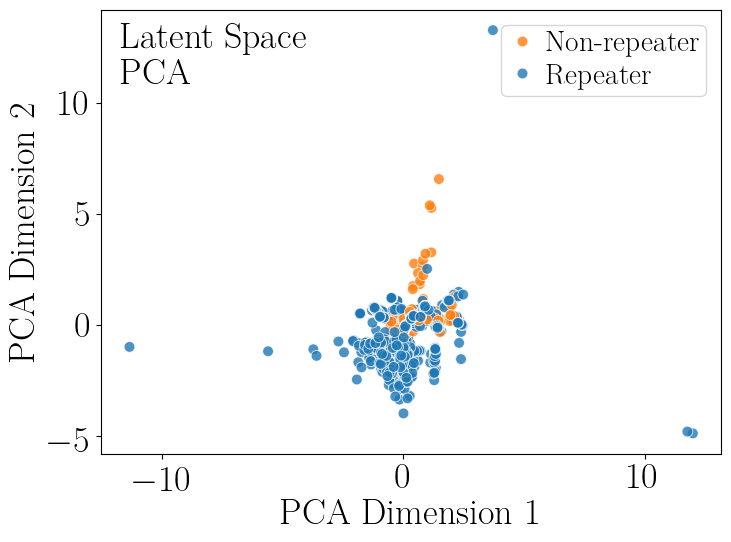

In [22]:
visualize_latent_space_pca(val_latent, val_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(left, top))

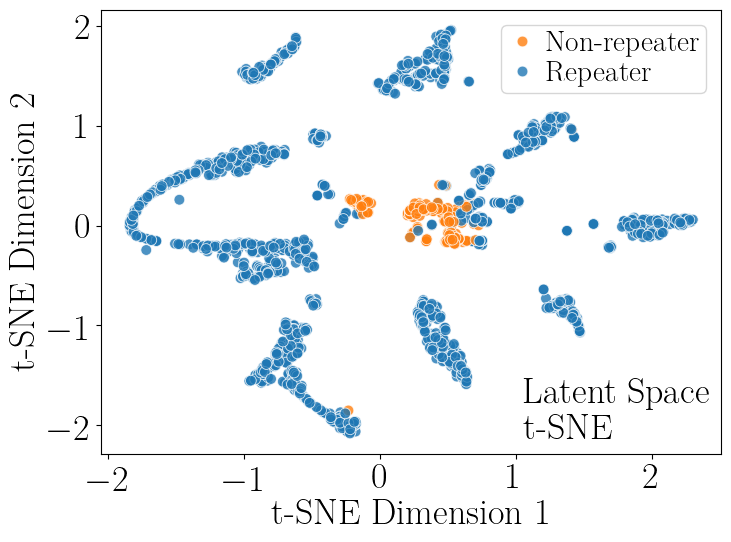

In [23]:
# cluster_and_visualize(val_latent, val_labels_string, title='Clusters in PCA-Transformed Latent Space', file_path='figs/full_dataset')
visualize_latent_space_tsne(val_latent, val_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(right, bottom))

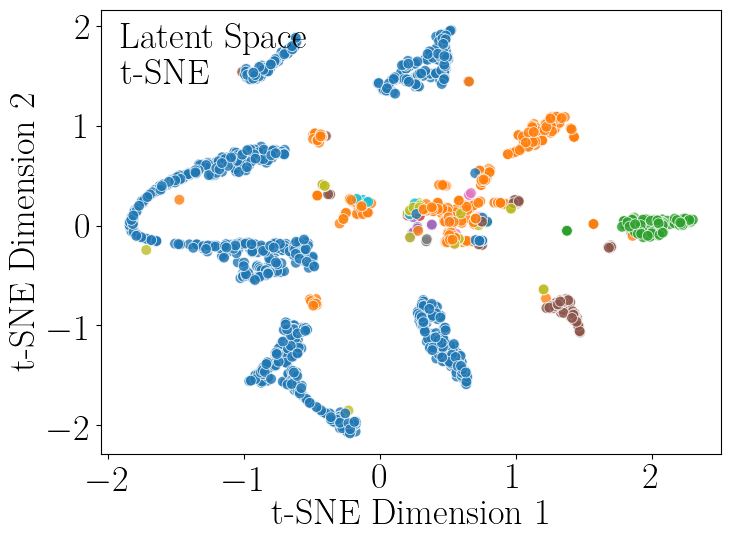

In [29]:
telescope_labels = original_data.loc[val_indices, 'Telescope'].values
visualize_latent_space_tsne(val_latent, telescope_labels, palette='tab10', file_path='figs/full_dataset',
                            title='t-SNE of Latent Space Representations by Telescope',
                            loc='upper right', n_col=2, many_classes=False, label_pos=(left, top), hide_legend=True)

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


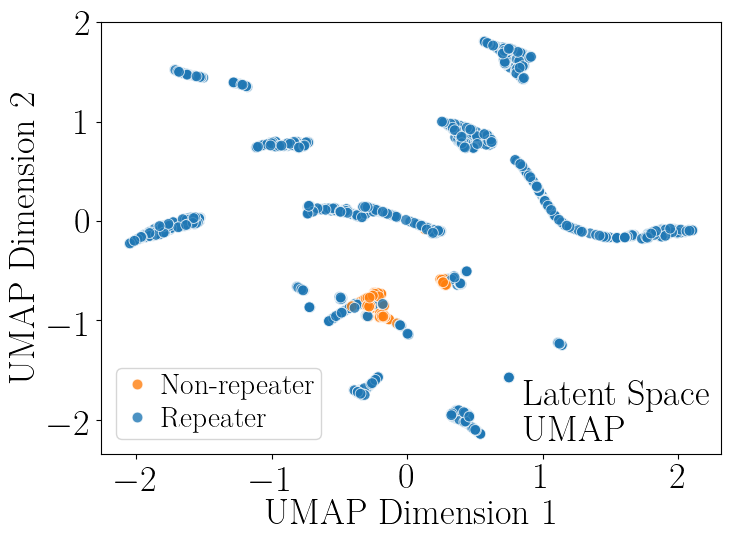

In [30]:
visualize_latent_space_umap(val_latent, val_labels_string, palette='tab10', file_path='figs/full_dataset', loc='lower left', label_pos=(right, bottom))

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 6 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is e

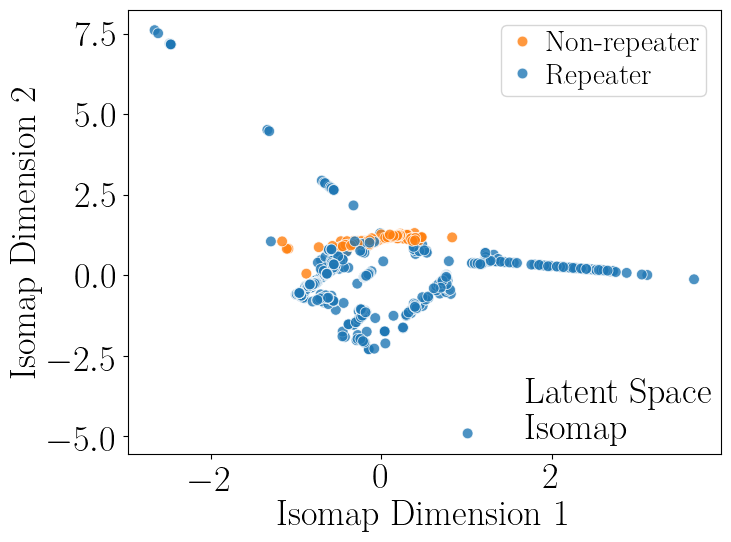

In [31]:
visualize_latent_space_isomap(val_latent, val_labels_string, palette='tab10', file_path='figs/full_dataset', label_pos=(right-0.01, bottom))

In [32]:
print(val_latent.shape)
print(val_labels_np.shape)
print(len(get_source_data_val_freq(20)))

def shortener(source_list, prefix='ID', other_label='Other'):
    """
    Assigns each unique FRB source in source_list an ID string (ID1, ID2, …),
    but if the source equals `other_label`, it stays as-is.
    
    Returns:
        id_map (dict): mapping from FRB signal → ID string (or `Other_label`)
        mapping_df (pd.DataFrame): two‑column table [ID, FRB Signal]
    """
    unique_frbs = pd.unique(source_list)
    
    id_map = {}
    ids, frbs = [], []
    counter = 1
    
    for frb in unique_frbs:
        if frb == other_label:
            id_str = other_label
        else:
            id_str = f"{prefix}{counter}"
            counter += 1
        
        id_map[frb] = id_str
        ids.append(id_str)
        frbs.append(frb)
    
    mapping_df = pd.DataFrame({
        'ID': ids,
        'FRB Signal': frbs
    })
    
    print("ID ↔ FRB Signal mapping:")
    print(mapping_df.to_string(index=False))
    
    return id_map, mapping_df



top10_sources = get_source_data_val_freq(10)

# 2) Build the shortener mapping and print the lookup table
id_map, mapping_df = shortener(top10_sources, prefix='ID')

# 3) Convert the top‑10 source names into their IDs
top10_ids = [id_map[src] for src in top10_sources]


(1733, 18)
(1733,)
1733
ID ↔ FRB Signal mapping:
   ID   FRB Signal
  ID1 FRB20180301A
  ID2 FRB20201124A
  ID3 FRB20121102A
  ID4 FRB20220912A
Other        Other
  ID5 FRB20240114A
  ID6 FRB20180916B
  ID7 FRB20190212A
  ID8 FRB20240316A
  ID9 FRB20190520B
 ID10 FRB20190303A


/tmp/ipykernel_375180/3947386509.py:14: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_frbs = pd.unique(source_list)


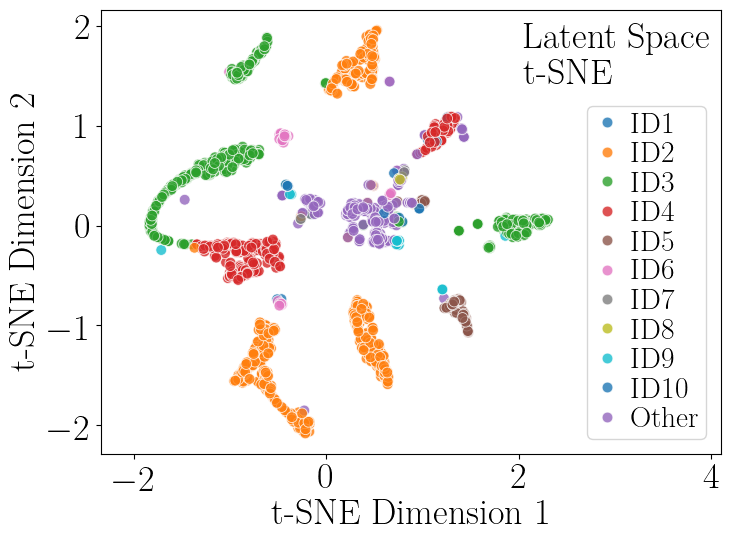

In [33]:
visualize_latent_space_tsne(val_latent, top10_ids, title='t-SNE of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset', n_col=1, loc='lower right', many_classes=True, label_pos=(right, top))

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


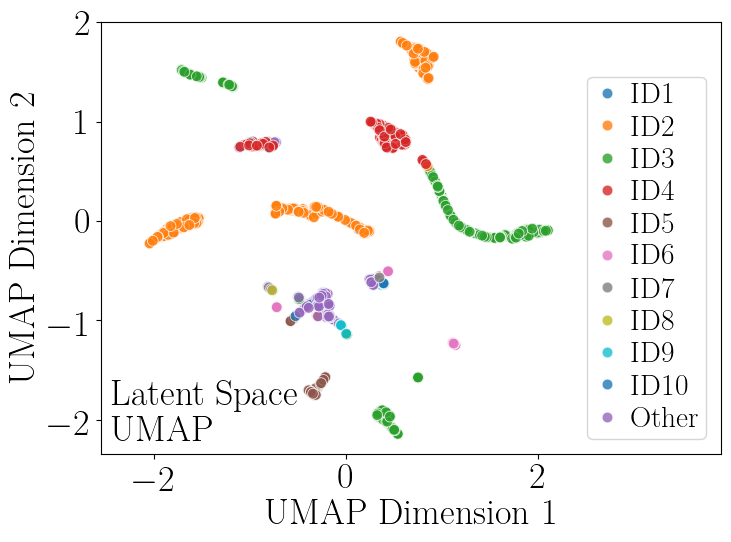

In [34]:
visualize_latent_space_umap(val_latent, top10_ids, title='UMAP of Latent Space Representations (Top 10 Sources)', palette='tab10', file_path='figs/full_dataset', loc='lower right', many_classes=True, label_pos=(left-0.015, bottom))

In [35]:
# Step 1: Identify the 5 most frequent repeaters
repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
top_5_repeaters = repeater_counts.head(5).index.tolist()

# Step 2: Filter the dataset to exclude these repeaters
filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
filtered_data_clean = frb_data_clean.loc[filtered_indices]
filtered_labels = labels.loc[filtered_indices]

# Step 3: Standardize the filtered dataset
scaler = StandardScaler()
filtered_data_scaled = scaler.fit_transform(filtered_data_clean)

# Step 4: Split the filtered dataset into train and validation sets
train_data_filtered, val_data_filtered, train_labels_filtered, val_labels_filtered = train_test_split(
    filtered_data_scaled, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_filtered = torch.tensor(train_data_filtered, dtype=torch.float32)
val_tensor_filtered = torch.tensor(val_data_filtered, dtype=torch.float32)
train_labels_tensor_filtered = torch.tensor(train_labels_filtered.values, dtype=torch.long)
val_labels_tensor_filtered = torch.tensor(val_labels_filtered.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_filtered = TensorDataset(train_tensor_filtered, train_labels_tensor_filtered)
val_dataset_filtered = TensorDataset(val_tensor_filtered, val_labels_tensor_filtered)

train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=batch_size, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=batch_size, shuffle=False)


In [36]:
# Step 7: Train the model with the filtered dataset
filtered_model_1 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

# set modle weights
filtered_model_1.load_state_dict(torch.load("weights/model_weights_filtered_repeaters.pth", map_location=device))

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(filtered_model_1, val_loader_filtered, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)



=== Final Evaluation ===
Validation Accuracy: 0.8905
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.86      0.96      0.91       150
    Repeater       0.94      0.81      0.87       124

    accuracy                           0.89       274
   macro avg       0.90      0.88      0.89       274
weighted avg       0.90      0.89      0.89       274

Confusion Matrix:
 [[144   6]
 [ 24 100]]



=== PCA Visualization ===


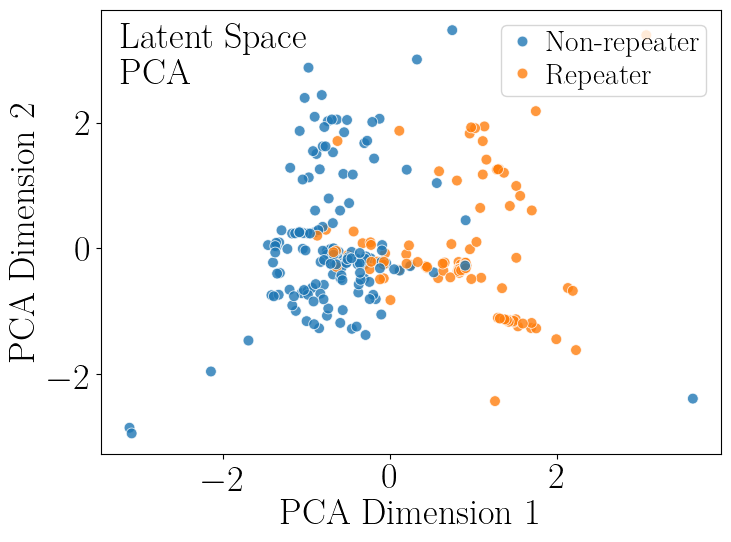

In [37]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_1, train_loader_filtered, device)
val_latent_filtered, val_labels_np_filtered = get_latent_representations(filtered_model_1, val_loader_filtered, device)
val_labels_np_string_filtered = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in val_labels_np_filtered])

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent_filtered, val_labels_np_string_filtered, title='PCA of Latent Space Representations (Top 5 Filtered)', file_path='figs/filtered_repeaters', label_pos=(left, top))


=== t-SNE Visualization ===


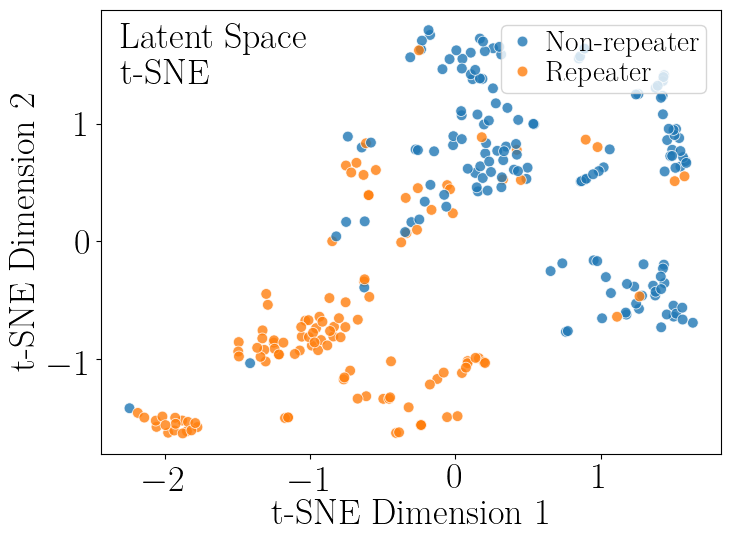

In [38]:
# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent_filtered, val_labels_np_string_filtered, title='t-SNE of Latent Space Representations (Top 5 Filtered)', palette='tab10', file_path='figs/filtered_repeaters', label_pos=(left, top))



=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


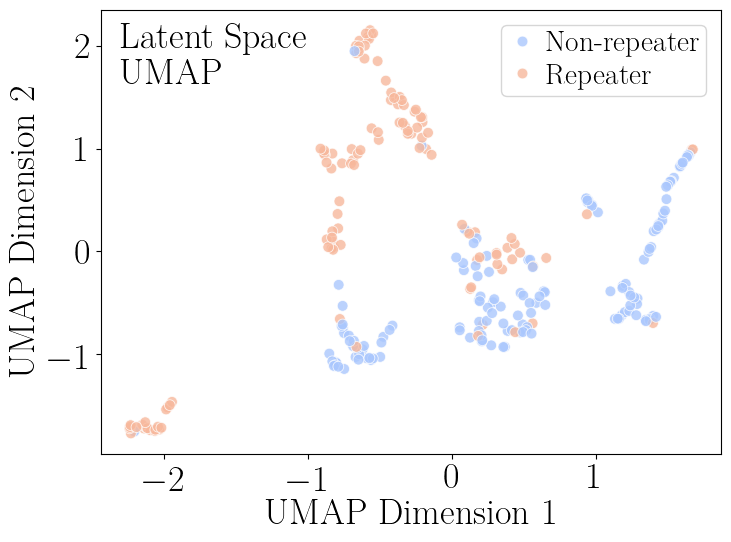

In [39]:

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent_filtered, val_labels_np_string_filtered, title='UMAP of Latent Space Representations (Top 5 Filtered)', palette='coolwarm', file_path='figs/filtered_repeaters', label_pos=(left, top))


=== Isomap Visualization ===


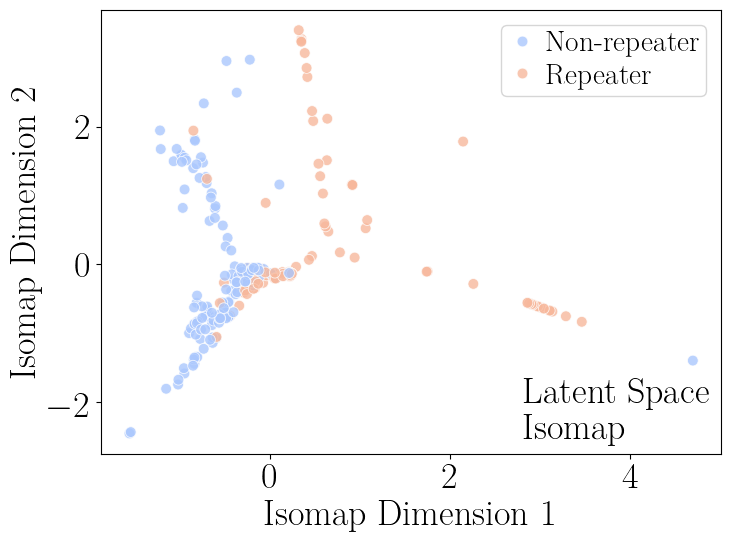

In [40]:
# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent_filtered, val_labels_np_string_filtered, title='Isomap of Latent Space Representations (Top 5 Filtered)', palette='coolwarm', file_path='figs/filtered_repeaters', label_pos=(right, bottom))

In [41]:
# Step 1: Remove all repeaters from the dataset
non_repeater_indices = frb_data[frb_data['Repeater'] == 0].index
no_repeater_data_clean = frb_data_clean.loc[non_repeater_indices]
no_repeater_labels = labels.loc[non_repeater_indices]

# Step 2: Standardize the no_repeater dataset
scaler = StandardScaler()
no_repeater_data_scaled = scaler.fit_transform(no_repeater_data_clean)

# Step 3: Split the no_repeater dataset into train and validation sets
train_data_no_repeater, val_data_no_repeater, train_labels_no_repeater, val_labels_no_repeater = train_test_split(
    no_repeater_data_scaled, no_repeater_labels, test_size=0.2, random_state=42, stratify=no_repeater_labels
)

# Step 4: Convert to PyTorch tensors
train_tensor_no_repeater = torch.tensor(train_data_no_repeater, dtype=torch.float32)
val_tensor_no_repeater = torch.tensor(val_data_no_repeater, dtype=torch.float32)
train_labels_tensor_no_repeater = torch.tensor(train_labels_no_repeater.values, dtype=torch.long)
val_labels_tensor_no_repeater = torch.tensor(val_labels_no_repeater.values, dtype=torch.long)

# Step 5: Create datasets and dataloaders
batch_size = 64
train_dataset_no_repeater = TensorDataset(train_tensor_no_repeater, train_labels_tensor_no_repeater)
val_dataset_no_repeater = TensorDataset(val_tensor_no_repeater, val_labels_tensor_no_repeater)

train_loader_no_repeater = DataLoader(train_dataset_no_repeater, batch_size=batch_size, shuffle=True)
val_loader_no_repeater = DataLoader(val_dataset_no_repeater, batch_size=batch_size, shuffle=False)

# Step 7: Train the model with the no_repeater dataset
filtered_model_2 = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

filtered_model_2.load_state_dict(torch.load("weights/best_model_no_repeaters.pth", map_location=device))

def evaluate_classifier_full_oneclass(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    # f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    # class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return conf_matrix, all_preds, all_labels

# Evaluate the model after training

conf_mat_no_repeaters, _, _ = evaluate_classifier_full_oneclass(filtered_model_2, val_loader_no_repeater, device)

conf_mat_no_repeaters

/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


array([[150]])

In [42]:
# Step 1: Extract latent representations
train_latent, train_labels_np = get_latent_representations(filtered_model_2, train_loader_no_repeater, device)
val_latent_no_repeaters, val_labels_np_no_repeaters = get_latent_representations(filtered_model_2, val_loader_no_repeater, device)


=== PCA Visualization ===


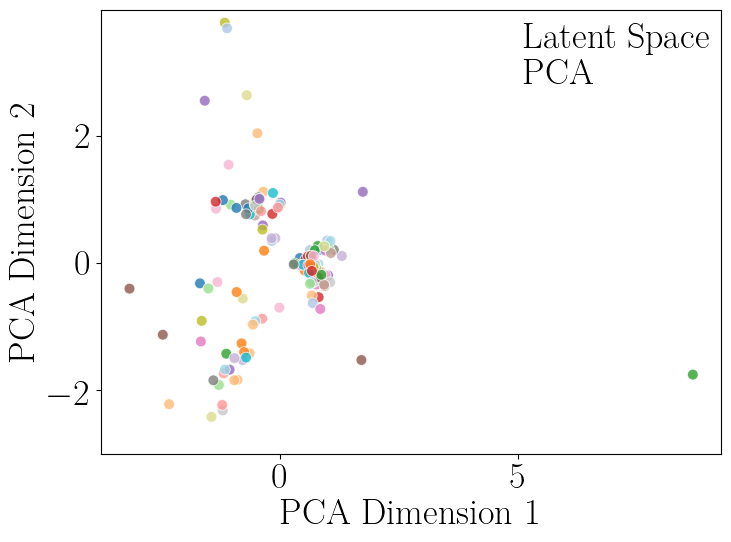


=== t-SNE Visualization ===


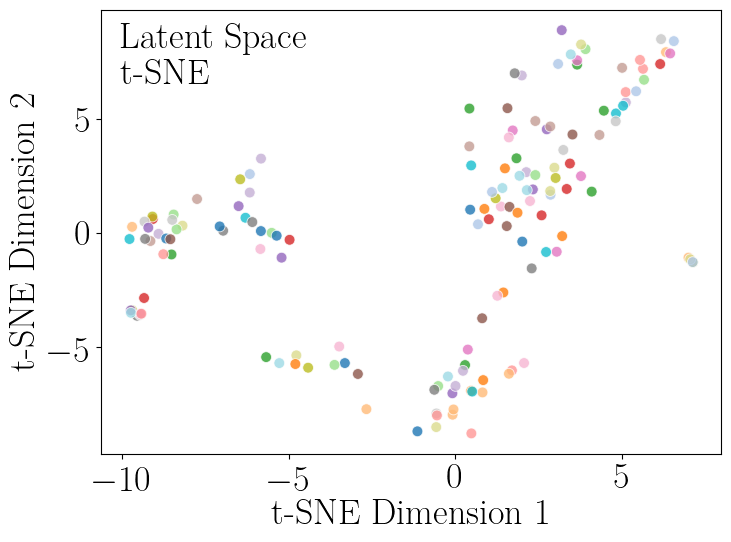


=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


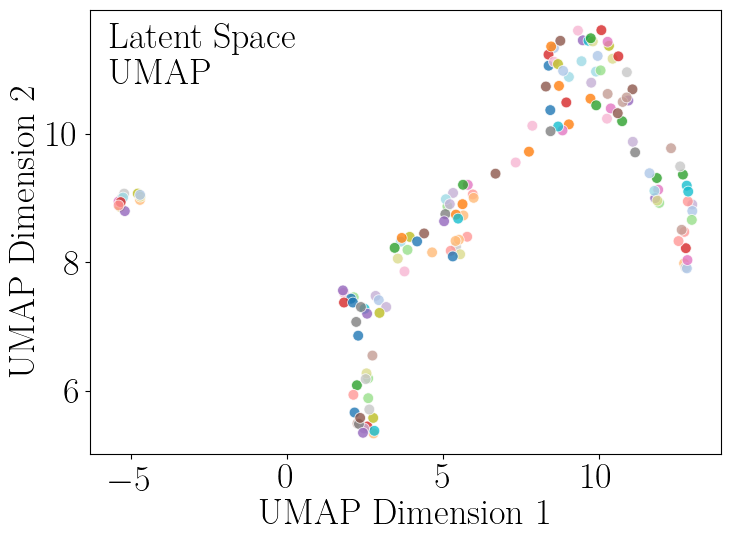

In [43]:

def visualize_latent_space_pca_source_nolegend(latent_representations,
                                               sources,
                                               title='PCA of Non-Repeater Latent Space (Colored by FRB)',
                                               palette='tab20',
                                               file_path='figs', label_pos=(0.05, 0.95), height_issue=False):
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0],
                    y=latent_2d[:, 1],
                    hue=sources,
                    palette=palette,
                    s=60,
                    alpha=0.8,
                    ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('PCA Dimension 1')
    ax.set_ylabel('PCA Dimension 2')
    ax.get_legend().remove()
    
    if height_issue:
        bottom_range_y = np.min(latent_2d[:, 1]) + 0.3
        top_range_y = np.max(latent_2d[:, 1])
        ax.set_ylim(bottom_range_y, top_range_y + 0.2)


    ax.text(label_pos[0], label_pos[1], 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()
    
    


def visualize_latent_space_tsne_nolegend(latent_representations,
                                         sources,
                                         title='t-SNE of Non-Repeater Latent Space (Colored by FRB)',
                                         palette='tab20',
                                         file_path='figs', label_pos=(0.05, 0.95)):
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_representations)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0],
                    y=latent_2d[:, 1],
                    hue=sources,
                    palette=palette,
                    s=60,
                    alpha=0.8,
                    ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.get_legend().remove()
    
    ax.text(label_pos[0], label_pos[1], 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()


def visualize_latent_space_umap_source_nolegend(latent_representations,
                                                sources,
                                                title='UMAP of Non-Repeater Latent Space (Colored by FRB)',
                                                palette='tab20',
                                                file_path='figs', label_pos=(0.05, 0.95)):
    reducer = umap.UMAP(n_components=2, random_state=42)
    latent_2d = reducer.fit_transform(latent_representations)

    fig, ax = plt.subplots(figsize=global_figsize)
    sns.scatterplot(x=latent_2d[:, 0],
                    y=latent_2d[:, 1],
                    hue=sources,
                    palette=palette,
                    s=60,
                    alpha=0.8,
                    ax=ax)

    # ax.set_title(title)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.get_legend().remove()

    ax.text(label_pos[0], label_pos[1], 'Latent Space \n UMAP', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.75)
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()



# Extract the source names for the validation set
val_sources_no_repeater = original_data.loc[val_labels_no_repeater.index, "Source"].values

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca_source_nolegend(val_latent_no_repeaters, val_sources_no_repeater, file_path='figs/no_repeaters', label_pos=(right, top), height_issue=True)

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne_nolegend(val_latent_no_repeaters, val_sources_no_repeater, file_path='figs/no_repeaters', label_pos=(left, top))

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap_source_nolegend(val_latent_no_repeaters, val_sources_no_repeater, file_path='figs/no_repeaters', label_pos=(left, top))


In [44]:
mismatched = {4: 0.2866666666666667, 2: 0.3, 3: 0.05333333333333334, 5: 0.4666666666666667}

In [45]:
n_clusters = 3
# mapping = {2: 1, 0: 0, 1:2, 3: 3, 4: 4}  # Example mapping for 5 clusters
# mapping= {0: 1, 1: 0, 2: 2}
mapping= {0: 1, 1: 2, 2: 0}

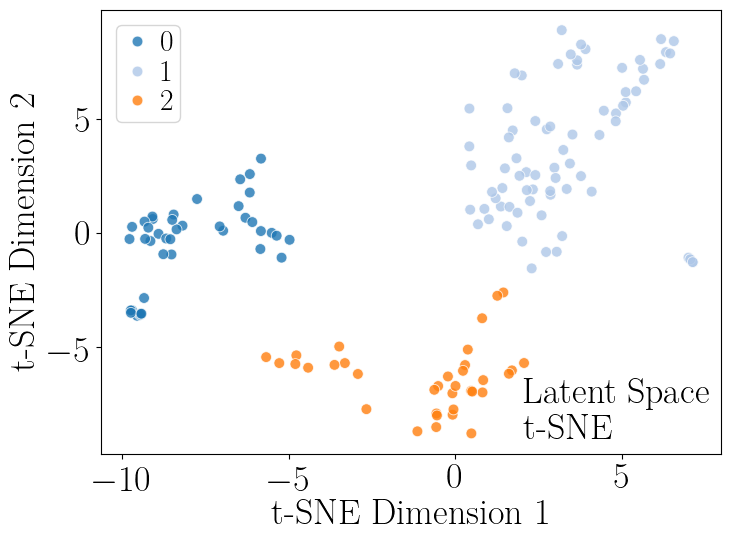

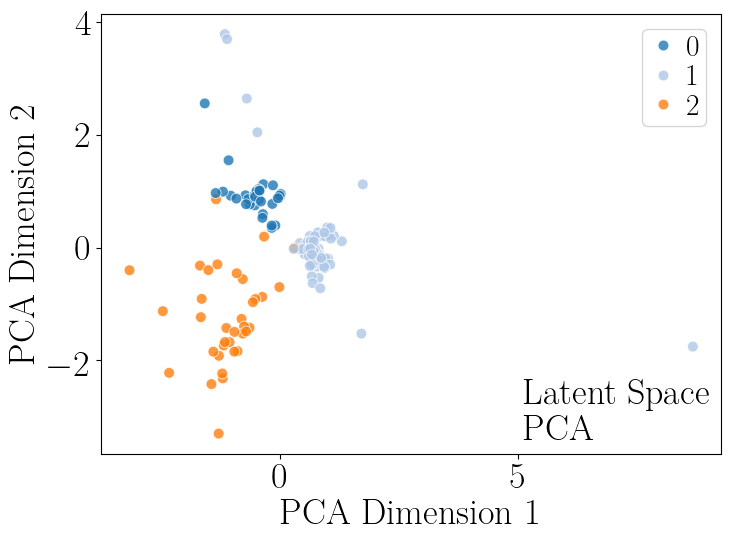

In [46]:
# Apply K-Means clustering on the t-SNE reduced latent space

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(val_latent_no_repeaters)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_1 = kmeans.fit_predict(latent_2d)


fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=cluster_labels_1,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)



ax.text(right, bottom, 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)



# ax.set_title(title)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')


plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_tsne_clustering_no_repeaters.svg'),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)

plt.show()

# Display the clusters in PCA space

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(val_latent_no_repeaters)

fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=cluster_labels_1,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)

ax.text(right, bottom, 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper right',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)




# ax.set_title(title)
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')


plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'pca_tsne_clustering_no_repeaters.svg'),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)


plt.show()

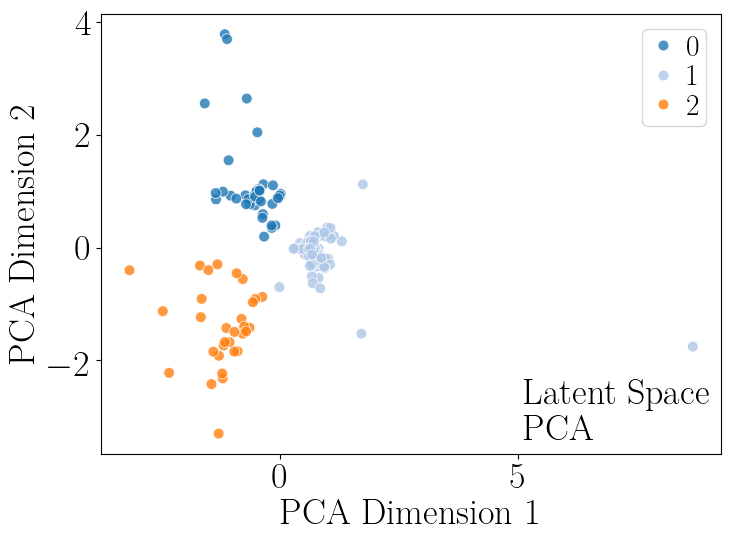

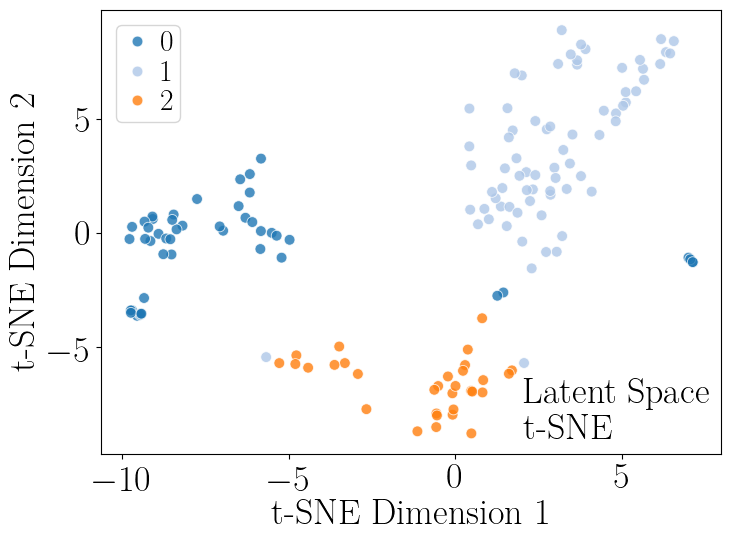

In [47]:
# Apply K-Means clustering on the PCA reduced latent space

pca_ruleof3 = PCA(n_components=2)
latent_2d = pca_ruleof3.fit_transform(val_latent_no_repeaters)

# Perform K-Means clustering
kmeans_ruleof3 = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_2 = kmeans_ruleof3.fit_predict(latent_2d)

# Make cluster 2 called cluster 0, cluster 0 called cluster 1, and cluster 1 called cluster 2

# remap cluster labels: 2→0, 0→1, 1→2
cluster_labels_2 = np.array([mapping[label] for label in cluster_labels_2])



fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=cluster_labels_2,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)



ax.text(right, bottom, 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper right',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)


# ax.set_title(title)
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')

plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'pca_pca_clustering_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

# Display the clusters in PCA space

tsne = TSNE(n_components=2, random_state=42)
# pca = PCA(n_components=2)
latent_2d = tsne.fit_transform(val_latent_no_repeaters)

fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=cluster_labels_2,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)

ax.text(right, bottom, 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)


# ax.set_title(title)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')


plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_pca_clustering_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

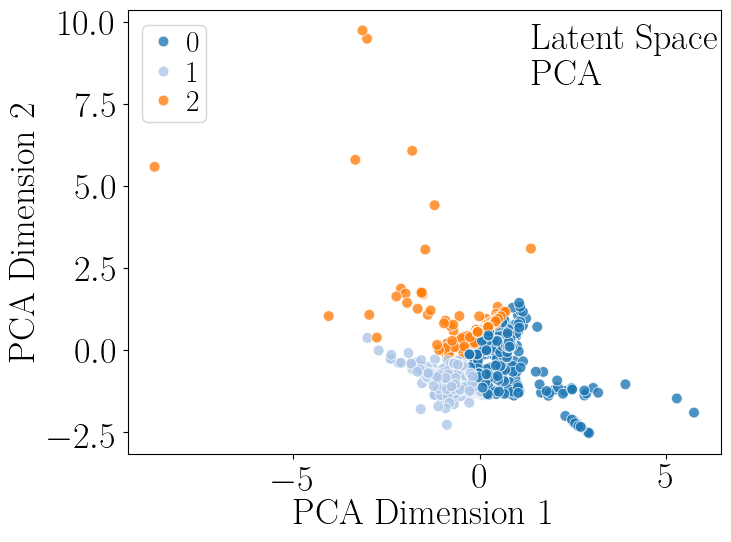

In [97]:
best_model_no_repeaters = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

best_model_no_repeaters.load_state_dict(torch.load("weights/best_model_no_repeaters.pth", map_location=device))


val_latent_full_data_no_repeater, m_1_dagger = get_latent_representations(best_model_no_repeaters, val_loader, device)

old_latent_2d_transformed = pca_ruleof3.transform(val_latent_full_data_no_repeater)


m_2_dagger = kmeans_ruleof3.predict(old_latent_2d_transformed)


convolved_labels= [
    f'{m}{v}' 
    for m, v in zip(m_1_dagger, m_2_dagger)
]


fig, ax = plt.subplots(figsize=global_figsize)
old_latent_2d_transformed.shape

sns.scatterplot(x=old_latent_2d_transformed[:, 0],
                y=old_latent_2d_transformed[:, 1],
                hue=m_2_dagger,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)


ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)

plt.text(right, top, 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'pca_pca_clustering_full_data_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

(1733, 18)


<Figure size 1000x600 with 0 Axes>

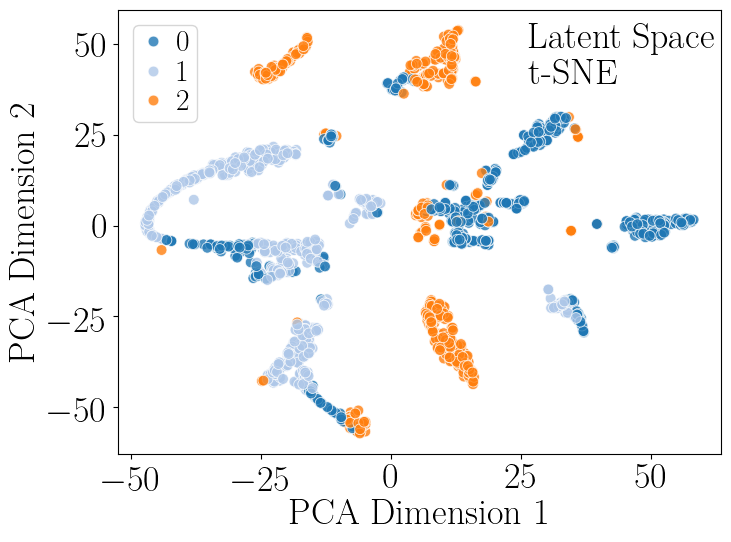

In [59]:
plt.figure(figsize=global_figsize)
tsne = TSNE(n_components=2, random_state=42)

print(val_latent.shape)


latent_2d_full = tsne.fit_transform(val_latent)
fig, ax = plt.subplots(figsize=global_figsize)

sns.scatterplot(x=latent_2d_full[:, 0],
                y=latent_2d_full[:, 1],
                hue=m_2_dagger
                , palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)

ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)

plt.text(right, top, 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_pca_clustering_full_data_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)    

plt.show()

(1733, 18)


<Figure size 1000x600 with 0 Axes>

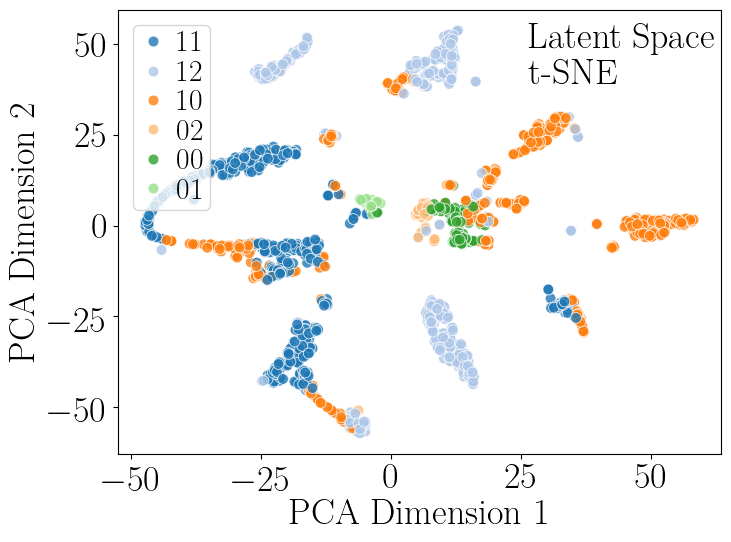

In [61]:
plt.figure(figsize=global_figsize)
tsne = TSNE(n_components=2, random_state=42)

print(val_latent.shape)


latent_2d_full = tsne.fit_transform(val_latent)
fig, ax = plt.subplots(figsize=global_figsize)

sns.scatterplot(x=latent_2d_full[:, 0],
                y=latent_2d_full[:, 1],
                hue=convolved_labels
                , palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)

ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)

plt.text(right, top, 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_pca_clustering_full_data_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)    

plt.show()

In [44]:

# find all indices where the two clusterings differ
mismatch_idx = np.where(cluster_labels_1 != cluster_labels_2)[0] 
mismatch_percentage = len(mismatch_idx) / len(cluster_labels_1)

print(f"Number of signals with differing labels: {len(mismatch_idx)}")
print(f"Percentage of signals with differing labels: {mismatch_percentage:.4f}")
print("Indices of those signals:", mismatch_idx)

Number of signals with differing labels: 8
Percentage of signals with differing labels: 0.0533
Indices of those signals: [ 16  23  33  42  53  64 117 121]


In [45]:
mismatched[n_clusters] = mismatch_percentage
mismatched = {4: 0.2866666666666667, 2: 0.3, 3: 0.05333333333333334, 5: 0.4666666666666667}

In [46]:
# get telescope data for val latent
val_telescope_data = pd.factorize(original_data.loc[val_labels_no_repeater.index, "Telescope"])[0]
val_telescope_data

array([0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 1, 1, 3, 1, 0, 0, 2, 0,
       0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 5, 0, 0, 0, 0, 0,
       1, 4, 0, 0, 0, 0, 1, 1, 0, 4, 2, 0, 1, 6, 2, 4, 2, 6, 0, 0, 1, 4,
       0, 0, 2, 1, 4, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 4, 5, 0, 2, 0,
       5, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 4, 0, 0, 0, 7, 0, 0, 0,
       1, 0, 0, 1, 0, 4, 0, 3, 0, 0, 2, 3, 0, 0, 0, 4, 0, 5, 0, 1, 0, 0,
       0, 0, 2, 1, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])

<>:7: SyntaxWarning: invalid escape sequence '\%'
<>:7: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_335388/4012001707.py:7: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('Clustering Mismatch (\%)')


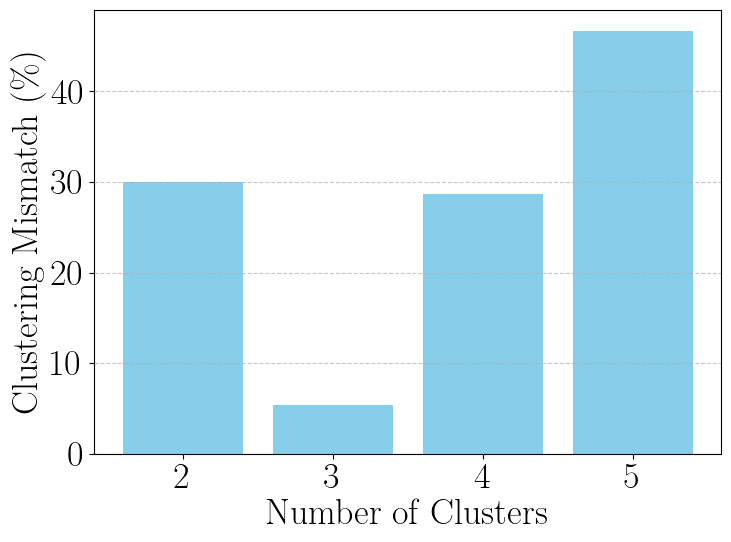

In [210]:
# plot the mismatch percentages for different cluster counts
import matplotlib.pyplot as plt
def plot_mismatch_percentages(mismatched):
    plt.figure(figsize=global_figsize)
    plt.bar(mismatched.keys(), [v * 100 for v in mismatched.values()], color='skyblue')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Clustering Mismatch (\%)')
    # plt.title('Mismatch Percentage Between Two Clusterings')
    plt.xticks(list(mismatched.keys()))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)
    
    plt.savefig(join('figs', 'no_repeaters_clustering', 'mismatch_percentages.svg'),
                dpi=200,
                format='svg',
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()
    
    
plot_mismatch_percentages(mismatched)


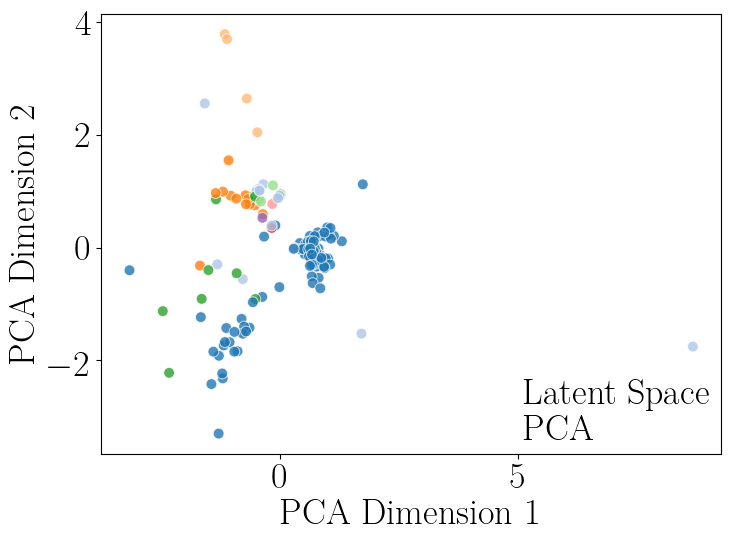

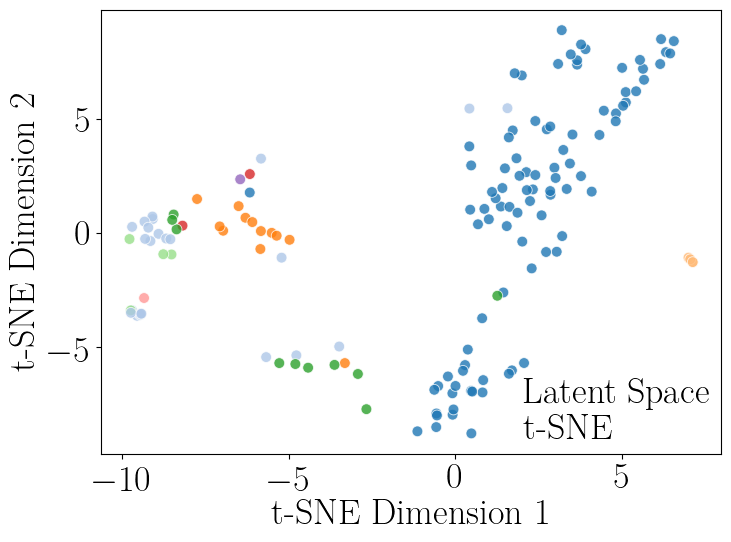

In [48]:
# Apply K-Means clustering on the PCA reduced latent space

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(val_latent_no_repeaters)

fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=val_telescope_data,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)



ax.text(right, bottom, 'Latent Space \n PCA', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    title='Cluster',
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper right',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)



# ax.set_title(title)
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.legend().remove()

plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'pca_telescope_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)


plt.show()

# Display the clusters in PCA space

tsne = TSNE(n_components=2, random_state=42)
# pca = PCA(n_components=2)
latent_2d = tsne.fit_transform(val_latent_no_repeaters)

fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=val_telescope_data,
                palette='tab20',
                s=60,
                alpha=0.8,
                ax=ax)

ax.text(right, bottom, 'Latent Space \n t-SNE', transform=ax.transAxes, fontsize=global_font_size,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0, edgecolor='none'))


ax.legend(
    title='Cluster',
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
)



# ax.set_title(title)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend().remove()

plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_telescope_no_repeaters.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)

plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN

# # Step 1: Identify the 5 most frequent repeaters
# repeater_counts = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts()
# top_5_repeaters = repeater_counts.head(5).index.tolist()

# # # Step 2: Filter the dataset to exclude these repeaters
# # filtered_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index
# # filtered_data_clean = frb_data_clean.loc[filtered_indices]
# # filtered_labels = labels.loc[filtered_indices]

# top_5_repeaters = frb_data[frb_data['Repeater'] == 1]['Source'].value_counts().head(5).index.tolist()

# SEED = 42
# rng = np.random.default_rng(SEED)
# torch.manual_seed(SEED)

# # Sample 10 signals from each top repeater
# sampled_indices = []
# for repeater in top_5_repeaters:
#     repeater_indices = frb_data[frb_data['Source'] == repeater].index
#     sampled = np.random.choice(repeater_indices, size=min(5, len(repeater_indices)), replace=False)
#     sampled_indices.extend(sampled)

# # Get all other indices excluding the top 5 repeaters
# non_top5_indices = frb_data[~frb_data['Source'].isin(top_5_repeaters)].index

# # Combine the sampled top5 and the rest
# final_indices = np.concatenate([non_top5_indices, sampled_indices])

# # Filter the clean data and labels accordingly
# subsampled_data_clean = frb_data_clean.loc[final_indices]
# subsampled_labels = labels.loc[final_indices]

# # Step 3: Standardize the filtered dataset
# scaler = StandardScaler()
# subsampled_data_clean = scaler.fit_transform(subsampled_data_clean)


# with open('subsampled_data_clean.pkl', 'wb') as f:
#     pickle.dump(subsampled_data_clean, f)
# with open('subsampled_labels.pkl', 'wb') as f:
#     pickle.dump(subsampled_labels, f)


In [75]:
with open('pickles/subsampled_data_clean.pkl', 'rb') as f:
    subsampled_data_clean = pickle.load(f)
with open('pickles/subsampled_labels.pkl', 'rb') as f:
    subsampled_labels = pickle.load(f)


In [76]:
# Step 4: Split the filtered dataset into train and validation sets
train_data_subsampled, val_data_subsampled, train_labels_subsampled, val_labels_subsampled = train_test_split(
    subsampled_data_clean, subsampled_labels, test_size=0.2, random_state=42, stratify=subsampled_labels
)

# Step 5: Convert to PyTorch tensors
train_tensor_subsampled = torch.tensor(train_data_subsampled, dtype=torch.float32)
val_tensor_subsampled = torch.tensor(val_data_subsampled, dtype=torch.float32)
train_labels_tensor_subsampled = torch.tensor(train_labels_subsampled.values, dtype=torch.long)
val_labels_tensor_subsampled = torch.tensor(val_labels_subsampled.values, dtype=torch.long)

# Step 6: Create datasets and dataloaders
batch_size = 64
train_dataset_subsampled = TensorDataset(train_tensor_subsampled, train_labels_tensor_subsampled)
val_dataset_subsampled = TensorDataset(val_tensor_subsampled, val_labels_tensor_subsampled)

train_loader_subsampled = DataLoader(train_dataset_subsampled, batch_size=batch_size, shuffle=True)
val_loader_subsampled = DataLoader(val_dataset_subsampled, batch_size=batch_size, shuffle=False)


# Step 7: Train the model with the filtered dataset
subsampled_model = SupervisedVAE(
    input_dim, 
    best_params["hidden_dim"], 
    best_params["latent_dim"], 
    best_params["dropout_rate"], 
    activation=get_activation_function(best_params["activation"])
).to(device)

subsampled_model.load_state_dict(torch.load("weights/filtered_model_sampled.pth", map_location=device))

<All keys matched successfully>

In [199]:
subsampled_labels =subsampled_labels.squeeze()


=== Final Evaluation ===
Validation Accuracy: 0.8817
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.90      0.88      0.89       150
    Repeater       0.86      0.88      0.87       129

    accuracy                           0.88       279
   macro avg       0.88      0.88      0.88       279
weighted avg       0.88      0.88      0.88       279

Confusion Matrix:
 [[132  18]
 [ 15 114]]

=== PCA Visualization ===


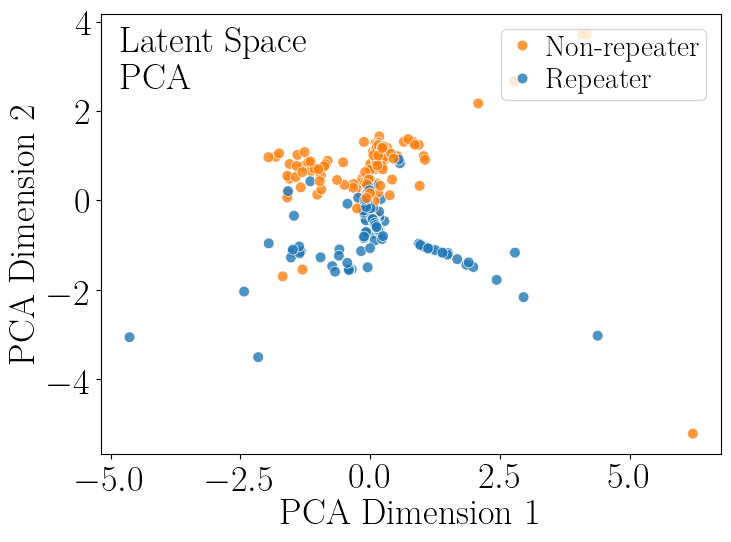


=== t-SNE Visualization ===


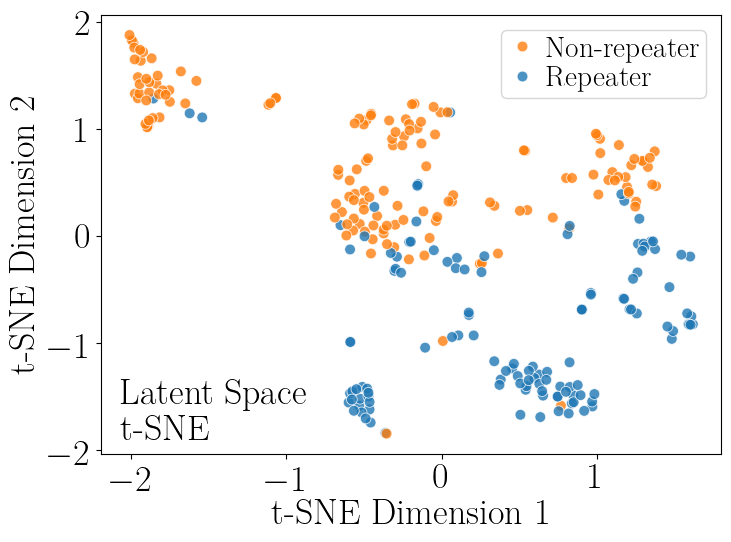


=== UMAP Visualization ===


/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/frb-analysis/.frb-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


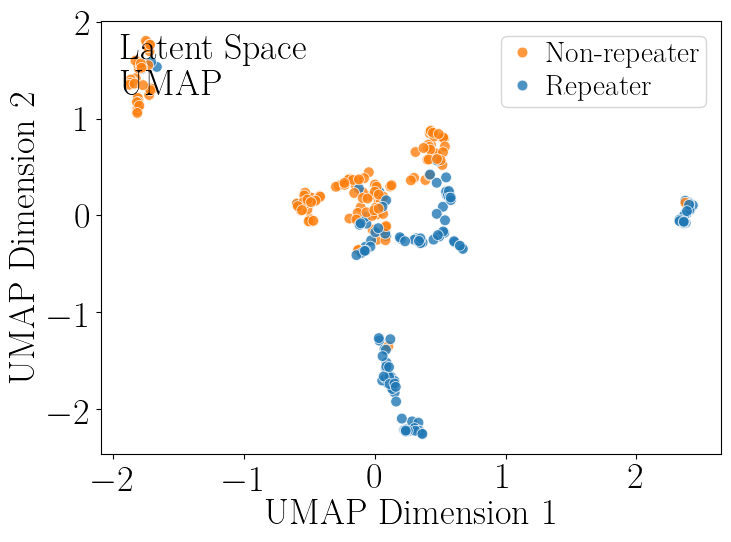


=== Isomap Visualization ===


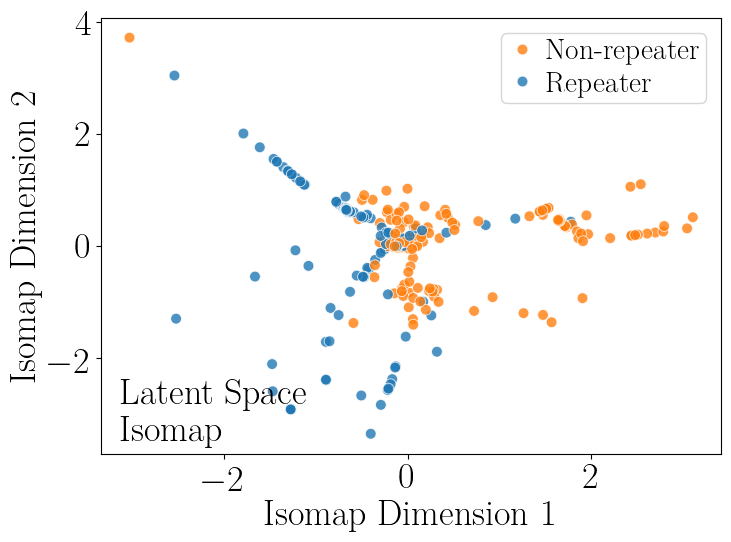

In [136]:

# Evaluate the model after training
val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier_full(subsampled_model, val_loader_subsampled, device)

print("\n=== Final Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)
# Step 1: Extract latent representations
val_latent_subsampled, val_labels_np_subsampled = get_latent_representations(subsampled_model, val_loader_subsampled, device)
val_labels_np_subsampled_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in val_labels_np_subsampled])

# Step 2: Visualize the latent space using PCA
print("\n=== PCA Visualization ===")
visualize_latent_space_pca(val_latent_subsampled, val_labels_np_subsampled_string, title='PCA of Latent Space Representations (Sampled)', file_path='figs/filtered_repeaters_sampled', loc="upper right", label_pos=(left, top))

# Step 4: Visualize the latent space using t-SNE
print("\n=== t-SNE Visualization ===")
visualize_latent_space_tsne(val_latent_subsampled, val_labels_np_subsampled_string, title='t-SNE of Latent Space Representations (Sampled)', palette='tab10', loc="upper right", file_path='figs/filtered_repeaters_sampled', label_pos=(left, bottom))

# Step 5: Visualize the latent space using UMAP
print("\n=== UMAP Visualization ===")
visualize_latent_space_umap(val_latent_subsampled, val_labels_np_subsampled_string, title='UMAP of Latent Space Representations (Sampled)', palette='tab10', file_path='figs/filtered_repeaters_sampled', label_pos=(left, top))

# Step 6: Visualize the latent space using Isomap
print("\n=== Isomap Visualization ===")
visualize_latent_space_isomap(val_latent_subsampled, val_labels_np_subsampled_string, title='Isomap of Latent Space Representations (Sampled)',palette='tab10', file_path='figs/filtered_repeaters_sampled', label_pos=(left, bottom))

2597    FRB20190520B
3180    FRB20181022D
2916    FRB20190128D
3414    FRB20200125A
2293    FRB20180814A
            ...     
5305    FRB20000622C
7581    FRB20181017A
3216    FRB20181225B
7566    FRB20180301A
7613    FRB20190303A
Name: Source, Length: 279, dtype: object
FRB20180309A is similar to FRB20201124A with a score of 2.00314 (Repeater difference)
FRB20180309A is similar to FRB20240114A with a score of 3.98530 (Repeater difference)
FRB20150418A is similar to FRB20220912A with a score of 3.37498 (Repeater difference)
FRB20150418A is similar to FRB20190520B with a score of 7.72357 (Repeater difference)
FRB20190112A is similar to FRB20190915D with a score of 0.84327 (Repeater difference)
FRB20190112A is similar to FRB20191106C with a score of 1.10929 (Repeater difference)
FRB20200917A is similar to FRB20200926A with a score of 0.95453 (Repeater difference)
FRB20200917A is similar to FRB20190127B with a score of 0.64459 (Repeater difference)
FRB20200917A is similar to FRB20190208A 

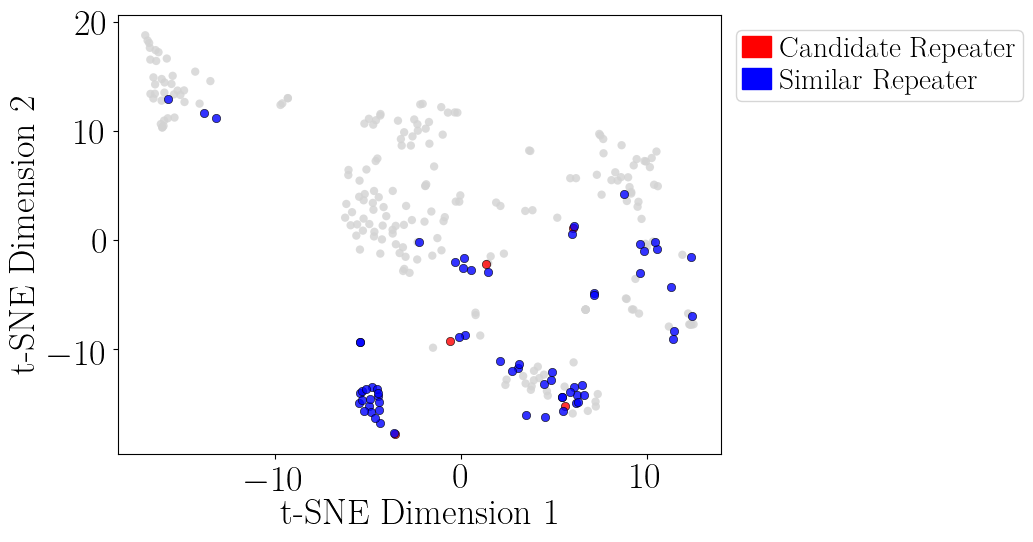

In [78]:
val_index = val_labels_subsampled.index
val_sources = original_data.loc[val_index, 'Source'].values

latent_df = pd.DataFrame(val_latent_subsampled, index=val_index)
latent_df['Source'] = val_sources

print(latent_df['Source'])

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(val_latent_subsampled)
distances, indices = nbrs.kneighbors(val_latent_subsampled)

# Simple nearest neighbor lookup (no cluster checks)
def find_similar(source):
    idx = latent_df[latent_df['Source'] == source].index[0]
    pos = list(latent_df.index).index(idx)

    neighbors = {}
    for i, neighbor_pos in enumerate(indices[pos][1:]):  # skip self (first neighbor)
        neighbor_idx = latent_df.index[neighbor_pos]
        neighbors[latent_df.loc[neighbor_idx, 'Source']] = float(distances[pos][i+1])
    return neighbors

# Track pairs where a non-repeater is similar to a repeater
highlight_non_repeaters = set()
highlight_repeaters = set()

for source in all_false_positives:
    # if source in garcia_list and source in zhu_ge_list and source in luo_list and source in latent_df['Source'].values:
    if source in latent_df['Source'].values:

        similar_source_data = find_similar(source)
        if similar_source_data:
            for similar_source, score in similar_source_data.items():
                source_repeater = frb_data[frb_data['Source'] == source]['Repeater'].values[0]
                neighbor_repeater = frb_data[frb_data['Source'] == similar_source]['Repeater'].values[0]

                if source_repeater != neighbor_repeater:
                    print(f"{source} is similar to {similar_source} with a score of {score:.5f} (Repeater difference)")
                    if source_repeater == 0:
                        highlight_non_repeaters.add(source)
                        highlight_repeaters.add(similar_source)
                    else:
                        highlight_non_repeaters.add(similar_source)
                        highlight_repeaters.add(source)
                        

# Now create a color array for visualization
# 0 = normal, 1 = non-repeater flagged, 2 = repeater flagged
colors = []
for source in latent_df['Source']:
    if source in highlight_non_repeaters:
        colors.append(-1)
    elif source in highlight_repeaters:
        colors.append(1)
    else:
        colors.append(0)

latent_df['highlight'] = colors


latent_df['highlight'] = latent_df['highlight'].replace({-1: 'Highlighted Non-Repeater', 1: 'Similar Repeater', 0: 'Normal'})

def visualize_latent_space_tsne_highlighting(latent_representations, labels,
                                             title='t-SNE of Latent Space Representations',
                                             file_path='figs'):

    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    import matplotlib.patches as mpatches
    from os.path import join
    import pandas as pd

    # convert to 2D with t-SNE
    latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_representations)

    # build DataFrame
    plot_df = pd.DataFrame(latent_2d, columns=['x', 'y'])
    plot_df['label'] = labels.values if hasattr(labels, 'values') else labels

    # color mapping
    label_to_color = {
        'Normal': 'lightgrey',
        'Highlighted Non-Repeater': 'red',
        'Similar Repeater': 'blue'
    }

    fig, ax = plt.subplots(figsize=global_figsize)

    # plot each class
    for label in ['Normal', 'Highlighted Non-Repeater', 'Similar Repeater']:
        subset = plot_df[plot_df['label'] == label]
        ax.scatter(subset['x'], subset['y'],
                   c=label_to_color[label],
                   label=label,
                   alpha=0.8,
                   edgecolors='none' if label == 'Normal' else 'black',
                   linewidths=0.5 if label != 'Normal' else 0)

    # ax.set_title(title)
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

    # create legend outside top right of plot
    legend_patches = [
        # mpatches.Patch(color='lightgrey', label='Normal'),
        mpatches.Patch(color='red', label='Candidate Repeater'),
        mpatches.Patch(color='blue', label='Similar Repeater'),
    ]
    ax.legend(handles=legend_patches,
            #   title='Class',
              borderpad=0.2,
              labelspacing=0.2,
              handlelength=1,
              handletextpad=0.3,
              borderaxespad=0.5,
              loc='upper left',
              bbox_to_anchor=(1, 1))

    plt.tight_layout()
    # leave space on right for legend
    fig.subplots_adjust(right=0.75)

    # save and display
    fig.savefig(join(file_path, f'{title}.svg'.replace(' ', '_')),
                dpi=200, format='svg', bbox_inches='tight', pad_inches=0.1)
    plt.show()


# Updated visualization call
visualize_latent_space_tsne_highlighting(val_latent_subsampled, latent_df['highlight'], title='t-SNE of Latent Space (Highlighting Repeater Differences)', file_path='figs/filtered_repeaters_sampled')

In [186]:
# collect non‑repeater/repeater pairs with distance
results = []
for source in all_false_positives:
    if source in latent_df['Source'].values:
        similar_source_data = find_similar(source)
        for similar_source, score in similar_source_data.items():
            source_repeater = frb_data.loc[frb_data['Source'] == source, 'Repeater'].iloc[0]
            neighbor_repeater = frb_data.loc[frb_data['Source'] == similar_source, 'Repeater'].iloc[0]
            if source_repeater != neighbor_repeater:
                if source_repeater == 0:
                    non_rep, rep = source, similar_source
                else:
                    non_rep, rep = similar_source, source
                results.append((non_rep, rep, score))

# export to CSV
df_export = pd.DataFrame(results, columns=['Non-Repeater', 'Repeater', 'Score'])
df_export.to_csv("ablation/ablated_results/base_similar_signals.csv", index=False)

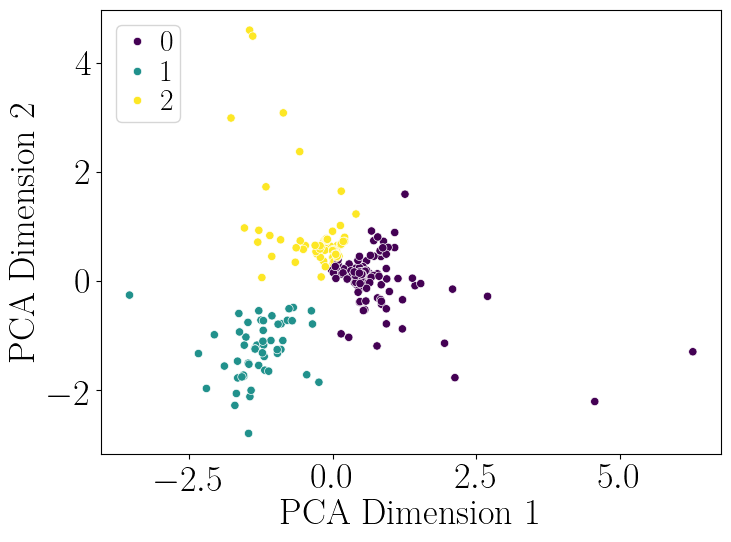

In [96]:
val_latent_no_repeater, val_labels_np_2 = get_latent_representations(best_model_no_repeaters, val_loader_subsampled, device)

filtered_2d_transformed = pca_ruleof3.transform(val_latent_no_repeater)
modified_labels = kmeans_ruleof3.predict(filtered_2d_transformed)

fig, ax = plt.subplots(figsize=global_figsize)

sns.scatterplot(x=filtered_2d_transformed[:, 0],
                y=filtered_2d_transformed[:, 1],
                hue=modified_labels,
                palette='viridis',
                legend='full', ax=ax)
ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')

ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='upper left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
    
)

plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'pca_pca_clustering_subsampled_data.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()

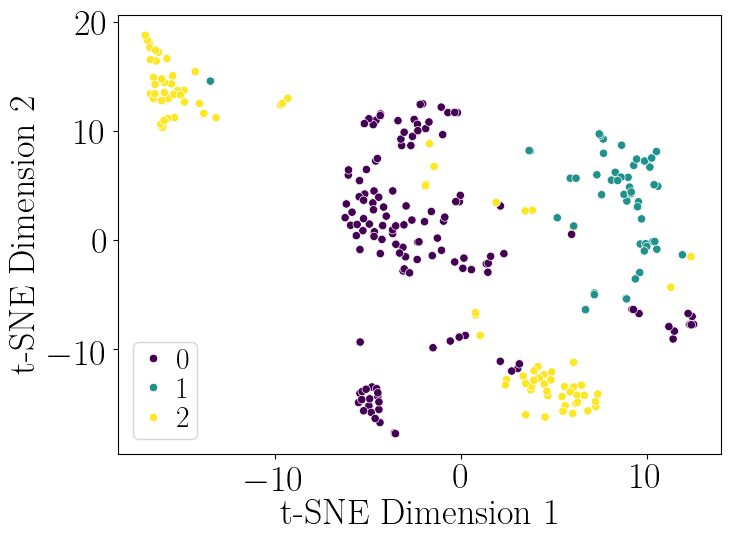

In [134]:

fig, ax = plt.subplots(figsize=global_figsize)
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(val_latent_subsampled)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=modified_labels,
                palette='viridis',
                legend='full', ax=ax)

ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='lower left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
    
)
plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_pca_clustering_subsampled_data.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()




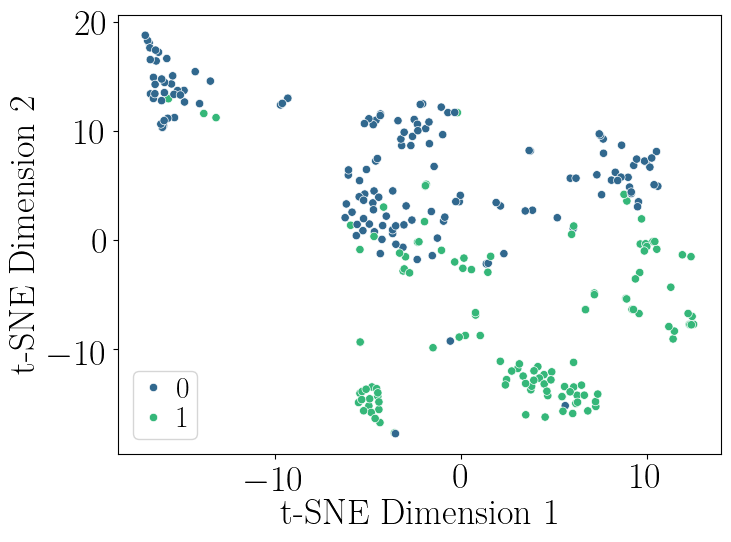

In [133]:

fig, ax = plt.subplots(figsize=global_figsize)

sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=val_labels_np_2,
                palette='viridis',
                legend='full', ax=ax)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='lower left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
    
)

plt.tight_layout()
fig.subplots_adjust(right=0.75)


plt.show()

<Figure size 1000x600 with 0 Axes>

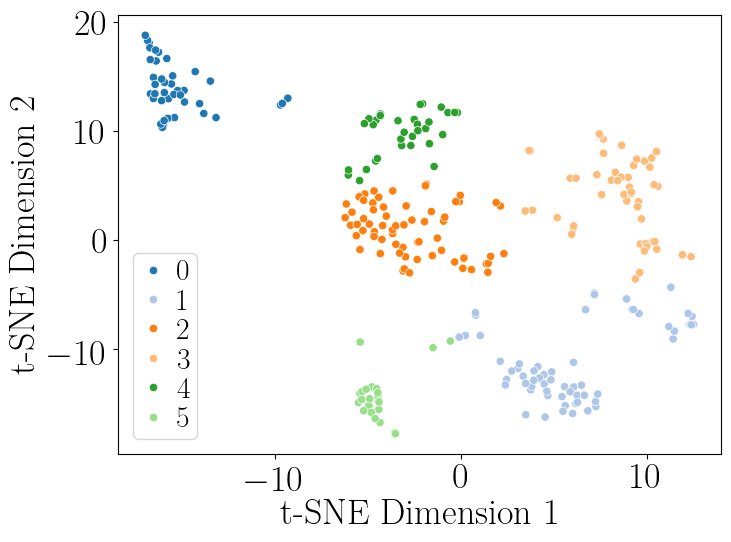

In [132]:
plt.figure(figsize=global_figsize)
kmeans_six = KMeans(n_clusters=6, random_state=42)
cluster_labels_6 = kmeans_six.fit_predict(latent_2d)

fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(x=latent_2d[:, 0],
                y=latent_2d[:, 1],
                hue=cluster_labels_6,
                palette='tab20',
                legend='full', ax=ax)
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.legend(
    borderpad=0.2,
    # reduce space between entries
    labelspacing=0.1,
    loc='lower left',
    # shorten the length of the legend lines
    handlelength=1,
    # reduce space between handle and text
    handletextpad=0.3,
    borderaxespad=0.5,
    
)

plt.tight_layout()
fig.subplots_adjust(right=0.75)
plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_tsne_clustering_subsampled_ruleof6data.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)
plt.show()

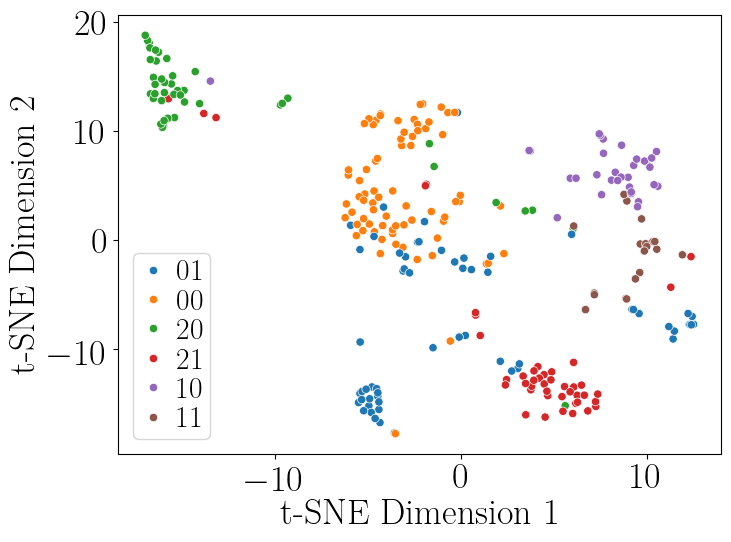

In [131]:
# combine class labels and permutation labels into descriptive names
combined_label_names = [
    f'{m}{v}' 
    for m, v in zip(modified_labels, val_labels_np_2)
]

# get a palette of 6 distinct colors
palette = sns.color_palette('tab10', 6)

# create scatter plot
fig, ax = plt.subplots(figsize=global_figsize)
sns.scatterplot(
    x=latent_2d[:, 0],
    y=latent_2d[:, 1],
    hue=combined_label_names,
    palette=palette,
    legend='full',
    ax=ax
)

# set axis labels
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')

# adjust legend appearance
ax.legend(
    borderpad=0.2,
    labelspacing=0.1,
    loc='lower left',
    handlelength=1,
    handletextpad=0.3,
    borderaxespad=0.5
)

plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.savefig(join('figs', 'no_repeaters_clustering', 'tsne_ruleof3_repeater_class_subsampled.svg'),
            dpi=200,
            format='svg',
            bbox_inches='tight',
            pad_inches=0.1)
# import necessary libraries

# display figure
plt.show()
